# Power and Thermal Budgeting
Scripts to determine and analyze the power and thermal requirements imposed upon different orbits.

### 1. Orbital Inputs
Orbits to simulate imported from STK.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from openpyxl import load_workbook
import os.path


wb_name = 'July19_July20ISS.xlsx'
sh_name = 'ISS Beta Angles'
n_days = 397

T_orbit = 1.54*60 # Orbit Period, minutes


wb = load_workbook(wb_name, data_only=True)


In [25]:
beta_angles = [0]
eclipse_frc = [0]

row = 2

while (wb[sh_name]['D'+str(row)].value != None):
    beta_angles.append(wb[sh_name]['E'+str(row)].value)
    eclipse_frc.append(wb[sh_name]['G'+str(row)].value)
    row += 1
beta_angles = np.array(beta_angles)
eclipse_frc = np.array(eclipse_frc)

### 2. Thermal Requirements
Heating requirements for Stasis and Experiment based on orbit. Taken from Joanna's MATLAB simulation.

In [100]:
def get_heats(exp_minT=33, sta_minT=10):
    #2.1 Define Constants 

    #target temperatures
    #exp_minT = 33
    #sta_minT = 10

    # Orbital parameters, thermoptical properties
    H = 550;                #Altitude [km]
    o = 5.67*np.power(10.0,-8.0);     #Stephan-Boltzmann Constant
    tot = 0.1418;           #Total Area [m^2]
    a = 0.72;               #Absorptivity 
    e = 0.58;               #Emissivity 

    #Radiator
    Ra = 0.1;               #Absorptivity
    Re = 0.8;               #Emissivity
    Arad = 0;               #Area of Radiator [m^2]
    K = 0.06;               #Bus-Payload Conductance [W/K]
    Pmax = 0.2;             #Max heat disipation 

    #2.2 Read Data
    Bdegs = np.array(beta_angles)
    Brad = Bdegs/180*np.pi
    Ef = np.array(eclipse_frc)

    #2.3 Empty Arrays
    Tcold = np.zeros(n_days+1)
    heatExp = np.zeros(n_days+1)
    heatSta = np.zeros(n_days+1)

    for i in range (1, n_days):
        #2.4.1 Albedo Correction
        Bd = Bdegs[i]
        if Bd > 0 and Bd < 20:
            c = Bd*(0.05 - 0.04)/20 + 0.04;
        elif Bd > 20 and Bd < 40:
            c = (Bd - 20)*(0.07 - 0.05)/20 + 0.05;
        elif Bd > 40 and Bd < 50:
            c = (Bd - 40)*(0.09 - 0.07)/10 +0.07;
        elif Bd > 50 and Bd < 60:
            c = (Bd - 50)*(0.12 - 0.09)/10 + 0.09;
        elif Bd > 60 and Bd < 70:
            c = (Bd - 60)*(0.16 - 0.12)/10 + 0.12; 
        elif Bd > 70 and Bd < 80:
            c = (Bd - 70)*(0.22 - 0.16)/10 + 0.16;
        else:
            c = (Bd - 80)*(0.31 - 0.22)/10 + 0.22;

        #2.4.2 Heat Flux Constants (Taken from SSO analysis)
        F = [0.0265, 1322.0, 217.0, 0.17+c]

        #2.4.3 Select and calculate extreme cases for each week
        coldT = np.power(o,-0.25) * np.power((F[1] * (a/e) * ( (1.0-Ef[i]) * (F[0]/tot) + 
                                               np.cos(Brad[i])/np.power((np.pi),2.0)*F[3]) 
                                                + F[2]/np.pi),(0.25)) - 10.0
        #2.5 Populate Array
        Tcold[i] = coldT
        heatExp[i] = (K*(exp_minT+273.15-coldT)) + (Arad*o*Re*(np.power(coldT,4) - np.power(4,4)))-Pmax
        heatSta[i] = (K*(sta_minT+273.15-coldT)) + (Arad*o*Re*(np.power(coldT,4) - np.power(4,4)))-Pmax

    return (heatExp, heatSta)

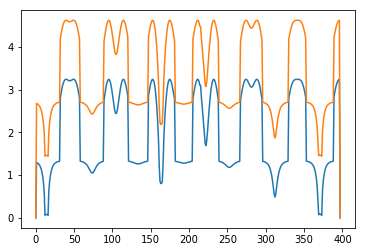

In [27]:
plt.plot(heatSta)
plt.plot(heatExp)
plt.show()

In [20]:
def movavg(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:]-ret[:-n]
    return ret[n-1:]/n

### 3. Power Generation
Power generation based on orbit.

In [35]:
pwr_in_sun = 6000 #Power generated in the sun, mW (extracted from Sam's old datasheets)
eff = 0.75 # efficiency

pwr_gen = pwr_in_sun * eff * (1-eclipse_frc)



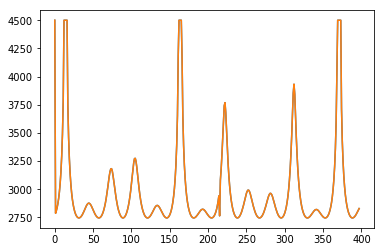

In [43]:
plt.plot(pwr_gen)
plt.show()

### 4. Power Budgeting
Start with defining the different components, and their power usage in different states. 

A component class that includes a dictionary of its possible states and its power generation.

In [38]:
class Component(object):
  def __init__ (self, name, states):
    # name: a describtive string
    self.name = name
    # states: a dictionary describing possible states of the form: {'state_name' : [nominal_power, budgeted_power]}
    # units are mW
    self.states = states
  def pwr(self,state, val = 1):
    return self.states[state][val]

Create the components on the satellite.

In [69]:
obc_ssm = Component("OBC",    {'REGULAR'  : [50, 55],
                              'LOPWR'     : [30, 33]})
 
eps_ssm = Component("EPS",    {'REGULAR' :  [50,55],
                               'KPALIVE' :  [150, 157.5],
                               'EXP'     :  [150, 157.5]})

com_ssm = Component("COM",    {'REGULAR' :  [50,55] })

com_li1 = Component("Li-1",   {'RX'      :  [200, 250],
                               'TX'      :  [10000, 10000],
                               'REGULAR' :  [200*.99 + 10000*.01 , 250*.99+10000*0.1]}) # assume transmitting 1% of the time
  
pay_ssm = Component("PAY",    {'KPALIVE' :  [50,55],
                               'EXP'     :  [200,210]})

pay_htr = Component("HEATER", {'KPALIVE' :  [0, 0],
                               'EXP'     :  [0, 0],
                               'OFF'     :  [0, 0]})

In [65]:
def get_total_pwr(sys_s, pay_s):
    return obc_ssm.pwr(sys_s) + eps_ssm.pwr(pay_s) + com_ssm.pwr(sys_s) + com_li1.pwr(sys_s) + pay_ssm.pwr(pay_s) + pay_htr.pwr(pay_s)

### 5. Simulation

In [98]:
t_sim = 300 #number of days to simulate
exp_start = 100
exp_end = 105

exp_minT = 33
sta_minT = 28

sta_h

pwr_in = np.zeros(t_sim)
pwr_out= np.zeros(t_sim)
margin = np.zeros(t_sim)


for i in range (1,300):
    if i < exp_start:
        pay_state = 'KPALIVE'
    elif exp_start - 1 < i and i < exp_end:
        pay_state = 'EXP'
    else:
        pay_state = 'KPALIVE'
    
    
    pay_htr.states['KPALIVE'][0] = heatSta[i] * 1000
    pay_htr.states['KPALIVE'][1] = heatSta[i] * 1100
    pay_htr.states['EXP'][0] = heatExp[i] * 1000
    pay_htr.states['EXP'][1] = heatExp[i] * 1100
    
    sys_state = 'REGULAR'
    
    pwr_in[i] = pwr_gen[i]
    pwr_out[i] = get_total_pwr(sys_state, pay_state)
    margin[i] = pwr_in[i] - pwr_out[i]
    
    



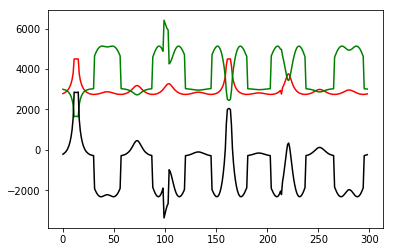

In [99]:
plt.plot(pwr_gen[1:300], 'r')
plt.plot(pwr_out[1:300], 'g')
plt.plot(margin[1:300], 'k')
plt.show()

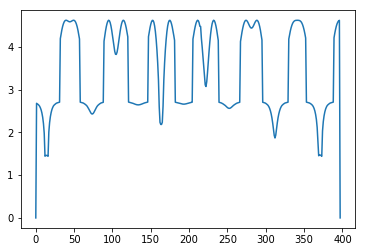

In [88]:
plt.plot(heatExp)
plt.show()